In [2]:
library(dplyr)
library(data.table)
library(parallel)
library(NMF)
library(CRF)
library(cowplot)
library(ggplot2)
library(ggrastr)
library(ggrepel)
library(pagoda2)
library(RColorBrewer)

In [3]:
# load the functions for running clean up
source('./decontam.R')


Two data files are needed for this tutorial, which can be downloaded at the following url:
https://nanostring.com/products/cosmx-spatial-molecular-imager/ffpe-dataset/nsclc-ffpe-dataset/ 
-"Processed Giotto Object"
-"Lung 5-1 Data files"


In [4]:
# load the molecule-level NSCLC spatial data
tx_dat <- read.csv(file='./Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/Lung5_Rep1_tx_file.csv')


In [5]:
# load the giotto object to get cell type annotations
load('./giotto_dat/SMI_Giotto_Object.RData')


Important: to run the pipeline of KNN graph -> NMF -> CRF, we need to include columns
in the molecule-level dataframe called:
- 'cell' specifying the cell that the molecule belongs to
- 'x','y','z' specifying the coordinates of the transcript. Note, if no z coordinates exist for your data, you can set that column to a constant value.
- 'gene' specifying the gene that the molecule corresponds to
- 'mol_id' a character which is unique to a give molecule (can just be row index)

In [6]:
# Creating a new cell ID column to match the metadata in giotto object
tx_dat$cell <- paste0('c_1_',tx_dat$fov,'_',tx_dat$cell_ID)

In [7]:
# extract relevant metadata from giotto object
cell_meta <- gem@cell_metadata$rna
cell_locs <- gem@spatial_locs$raw
meta_total <- cbind.data.frame(cell_locs[,c(1:2)],cell_meta)

# subset to a single donor/replicate
cell_annot <- meta_total[meta_total$Run_Tissue_name=='Lung5_Rep1',]
colnames(cell_annot)[3] <- 'cell'
colnames(cell_annot)[34] <- 'celltype'

# subsetting data to same cells we have annotations for
df <- tx_dat[tx_dat$cell %in% cell_annot$cell,]

# append cell type annotations to molecule-level data
match_ndx <- match(df$cell,cell_annot$cell)
df$celltype <- cell_annot$celltype[match_ndx]


In [8]:
# Change x and y coordinate column names
colnames(df)[3:4] <- c('x','y')

# Change gene column name
colnames(df)[8] <- c('gene')

# adding a column for molecule ID
df$mol_id <- as.character(1:nrow(df))


In [9]:
# converting coordinate units from pixels to microns based on information from their publication
df$x <- (df$x * 180) / 1000
df$y <- (df$y * 180) / 1000

# assigning z-coordinates to an expected height in microns
df$z <- (df$z * 800) / 1000

Next, let's look at the distribution of cell types and annotated regions over the tissue section

In [10]:
# rename tumor cells
cell_annot$celltype <- sapply(cell_annot$celltype,function(x){
    if (x %in% c('tumor 12','tumor 13','tumor 14','tumor 6','tumor 9','tumor 5')) {
        return('malignant')
    } else {
        return(x)
    }
}) 

# group all immune cells under one annotation for the visualization
cell_annot$cell_type_coarse <- sapply(cell_annot$celltype,function(x){
  if (x=='B-cell' | x=='NK' | x=='T CD4 memory' | x=='T CD4 naive' | x=='T CD8 memory' | x=='T CD8 naive' | x=='Treg' | x=='plasmablast' | x=='mast' | x=='mDC' | x=='monocyte' | x=='pDC' | x=='neutrophil') {
    return('immune other')
  } else {
    return(x)
  }
})

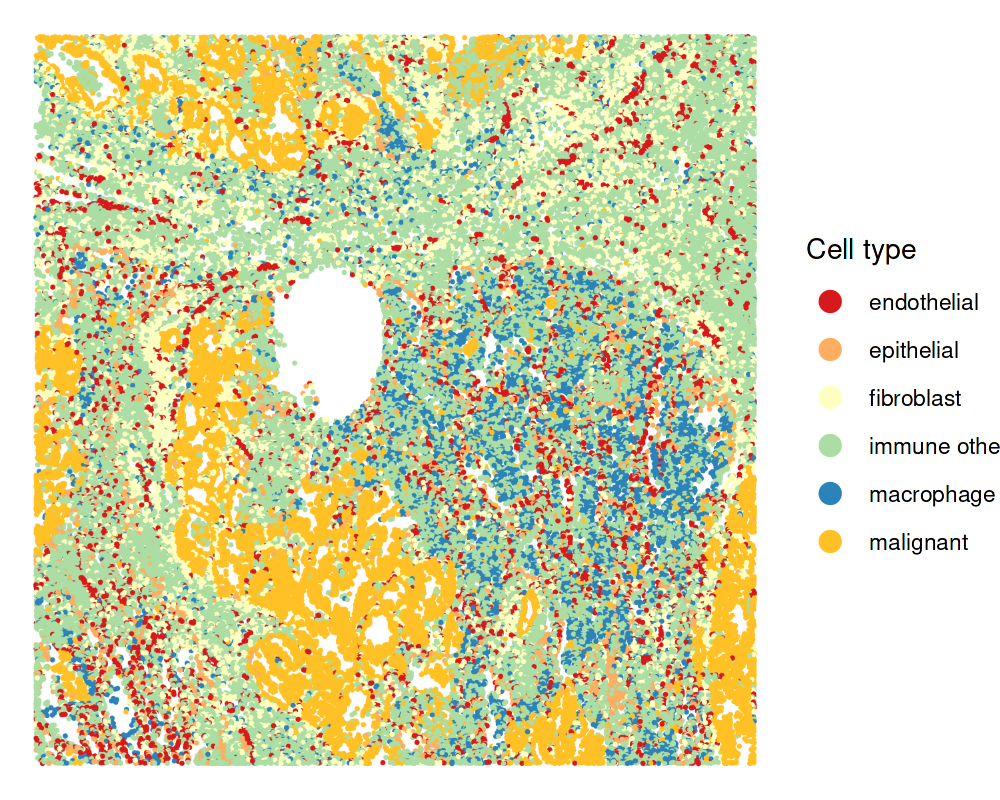

In [11]:
# first show cells colored by cell type
myColors <- RColorBrewer::brewer.pal(5, 'Spectral')
myColors <- c(myColors,'goldenrod1')
p <- ggplot(cell_annot,aes(x=sdimx,y=sdimy,color=cell_type_coarse)) +
  geom_point_rast(size=.001) +
  scale_colour_manual(values = myColors) +
  guides(colour = guide_legend(override.aes = list(size=3))) +
  labs(color='Cell type') +
  theme_void() +
  theme(legend.text=element_text(size=8),
        legend.title=element_text(size=10))

options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 200)
p

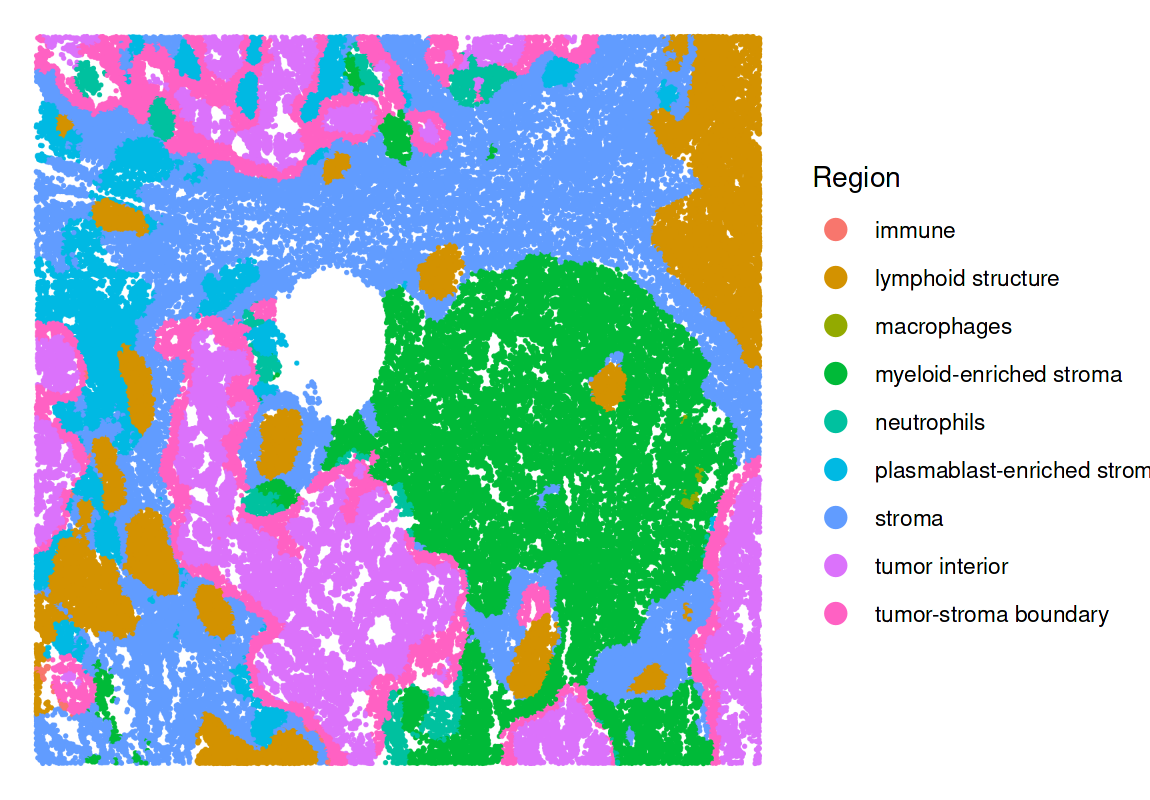

In [12]:
# next, show cells colored by region assignment
p <- ggplot(cell_annot,aes(x=sdimx,y=sdimy,color=niche)) +
  geom_point_rast(size=.001) +
  guides(colour = guide_legend(override.aes = list(size=3))) +
  labs(color='Region') +
  theme_void() +
  theme(legend.text=element_text(size=8),
        legend.title=element_text(size=10))

options(repr.plot.width = 5.75, repr.plot.height = 4, repr.plot.res = 200)
p

Next, we'll illustrate how fibroblasts in the tumor interior region appear to overexpress malignant cell markers relative to fibroblasts in the stroma. This effect will be apparent when running differential expression between fibroblasts in the tumor interior versus the stroma regions, as malignant markers will appear to be upregulated for fibroblasts in the tumor interior.

In [13]:
# computing a counts matrix from the molecule level data
dat_orig <- df %>% count(gene, cell) %>%
      reshape2::dcast(cell ~ gene, value.var = 'n', fill = 0) %>%
      as.data.frame() %>%
      tibble::column_to_rownames('cell')
dat_orig <- t(dat_orig)

# subset to just one cell type
rownames(cell_annot) <- cell_annot$cell
cells_keep <- cell_annot$cell[cell_annot$celltype=='fibroblast']
meta_orig <- cell_annot[cells_keep,]
dat_orig <- dat_orig[,cells_keep]

# add annotation for regions to compare with de
meta_orig$regions_compare <- sapply(meta_orig$niche,function(x) {
  if (x=='tumor interior') {
    return('tumor')
  } else if (x=='stroma') {
    return('stroma')
  } else {
    return(NA)
  }
})

# reduce data to just the cells in the tested regions
cells_keep <- rownames(meta_orig)[!is.na(meta_orig$regions_compare)]
meta_orig <- meta_orig[cells_keep,]
dat_orig <- dat_orig[,cells_keep]

print(dim(dat_orig))
print(dat_orig[1:5,1:5])

[1]  980 7031
     c_1_1_18 c_1_1_25 c_1_1_26 c_1_1_36 c_1_1_58
AATK        0        0        0        0        0
ABL1        0        0        0        0        0
ABL2        0        0        0        0        0
ACE         0        0        0        0        0
ACE2        0        0        0        0        0


In [14]:
## run de for fibroblasts between tumor and stroma
dat_pgda_orig <- basicP2proc(dat_orig, n.cores=1, min.cells.per.gene=0,
                            n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_orig$regions_compare
names(regions_compare) <- rownames(meta_orig)
de_out_orig <- dat_pgda_orig$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                            upregulated.only=FALSE,append.auc = TRUE)
de_out_orig <- de_out_orig[['tumor']]

5961 cells, 980 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

25 overdispersed genes ... 25

persisting ... 

done.

running PCA using 980 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 1 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 976 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


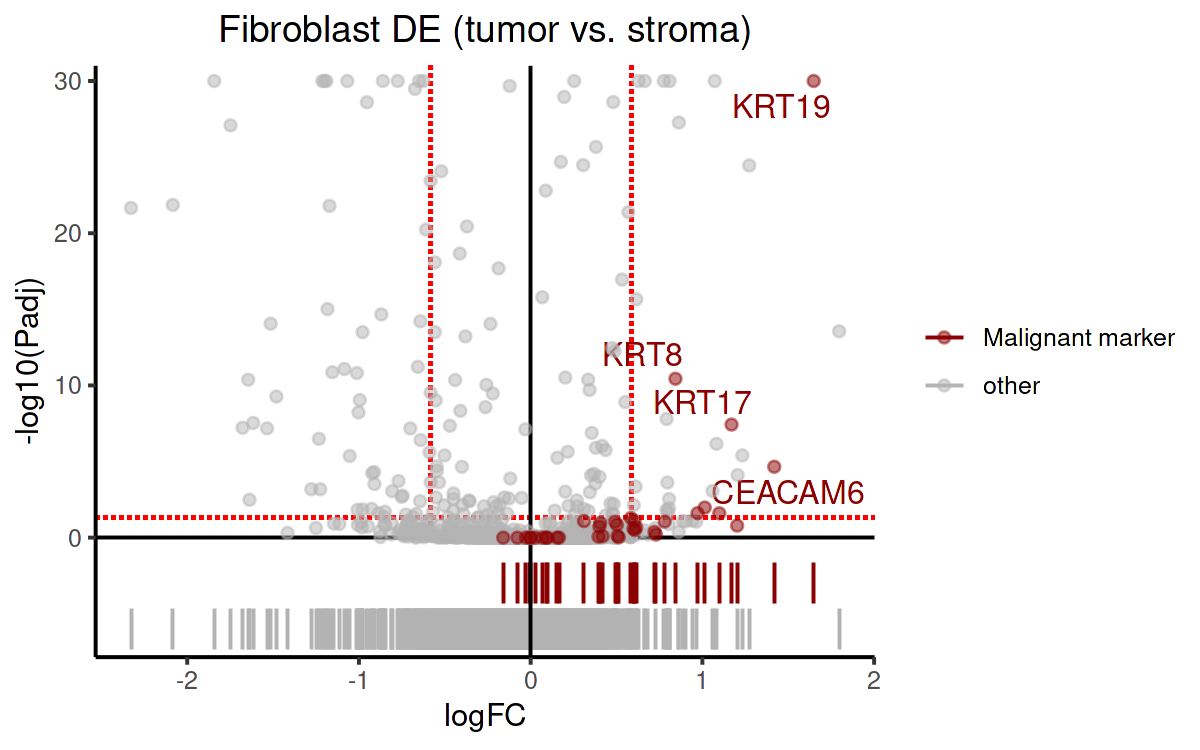

In [15]:
options(repr.plot.width = 6, repr.plot.height = 3.75, repr.plot.res = 200)

tumor.marker.genes <- c("KRT19",   "KRT8",    "KRT18",   "TACSTD2", "CEACAM6", "CDH1",    "EPCAM",
                       "CLDN4",   "SFN",     "PHLDA2",  "DDR1",    "AGR2",    "KRT6A",   "KRT17",
                       "CD24",    "KRT5",    "AQP3",    "SLC2A1",  "KRT7",    "COL17A1", "FASN",
                       "KRT15",   "ITGA2",   "ERBB3",   "S100A2",  "SPINK1",  "ITGB4",   "PIGR",
                       "SOX2",    "ITGA3",   "CYSTM1",  "NTRK2",   "MAPK13",  "CCND1",   "HDAC1",
                       "EGFR")

## making volcano plot for original DE
de_out_orig$padj <- 2*pnorm(abs(de_out_orig$Z), mean = 0, sd = 1, lower.tail = FALSE) # convert z back to padj
de_out_orig$logpv <- -log10(de_out_orig$padj)
genes_to_label <- c('KRT19','KRT8','KRT17','CEACAM6')
ndx_lab <- which(de_out_orig$Gene %in% genes_to_label)
de_out_orig$top_mark_other <- NA
de_out_orig[ndx_lab,'top_mark_other'] <- de_out_orig$Gene[ndx_lab]
de_out_orig$logpv[de_out_orig$logpv>30] <- 30
ymax <- max(de_out_orig$logpv,na.rm=TRUE) + 1
de_out_orig$mark_other <- de_out_orig$Gene %in% tumor.marker.genes
de_out_orig$mark_other <- factor(de_out_orig$mark_other,levels=c(TRUE,FALSE))
levels(de_out_orig$mark_other) <- c('Malignant marker', 'other')

myColors <- c('red4','grey70')

# Helper variables
limits <- range(de_out_orig$logpv,na.rm = TRUE,finite = TRUE)
step   <- diff(limits) * 0.1
size   <- 0.45 * step

de_out_orig$mark_other <- factor(de_out_orig$mark_other,levels=c('Malignant marker','other'))
bottom_lim <- min(limits[1] - as.numeric(de_out_orig$mark_other) * step - size) - .5

p <- ggplot(de_out_orig,aes(x=M,y=logpv,color=mark_other,label=top_mark_other)) + 
  geom_segment(aes(y=ymax,yend=0,x = log2(1.5)),color='red',linetype='dashed') +
  geom_segment(aes(y=ymax,yend=0,x = -log2(1.5)),color='red',linetype='dashed') +
  geom_hline(yintercept=0) +
  geom_segment(aes(x=-Inf,xend=Inf,y = -log10(.05)),color='red',linetype='dashed') +
  geom_segment(
    aes(
      color = mark_other,
      xend = M,
      y    = limits[1] - as.numeric(mark_other) * step + size,
      yend = limits[1] - as.numeric(mark_other) * step - size
    )
  ) +  
  geom_text_repel(size=4, show.legend = FALSE) +
  geom_vline(xintercept=0) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='other',],alpha=.5,size=1.5) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='Malignant marker',],alpha=.5,size=1.5) +
  scale_y_continuous(limits=c(bottom_lim,ymax),expand = c(0, 0)) +
  xlab('logFC') +
  ylab('-log10(Padj)') +
  ggtitle('Fibroblast DE (tumor vs. stroma)') +
  scale_colour_manual(breaks = c('Malignant marker','other'), values = myColors) +
  theme_classic(base_line_size = .5) +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank())

p

In the above plot we can see that malignant marker genes rise to the top of the DE genes in fibroblast cells. Specifically, they appear upregulated for fibroblasts in the tumor relative to stroma regions. The malignant marker genes were identified in a separate scRNA-seq dataset.

Next, we'll apply our correction method to identify and remove admixture genes from the fibroblast cells.

In [17]:
# subset to only fibroblasts inside the tumor interior niche to help pull out the contamination signal
ct <- 'fibroblast'
df <- df[df$celltype==ct,]

match_ndx <- match(df$cell,cell_annot$cell)
df$niche <- cell_annot$niche[match_ndx]
df_tumor <- df[df$niche=='tumor interior',]

# removing unneeded columns from the df
df_tumor <- df_tumor[,c('cell','gene','niche','mol_id','x','y','z')]

print(head(df_tumor))

           cell     gene          niche mol_id        x        y   z
826495 c_1_2_76     MMP1 tumor interior 493361 2399.334 28573.55 7.2
826496 c_1_2_76 HLA-DQB1 tumor interior 493362 2397.822 28572.18 2.4
826497 c_1_2_76   COL1A2 tumor interior 493363 2398.117 28570.65 2.4
826498 c_1_2_76     C1QB tumor interior 493364 2397.170 28573.14 2.4
826499 c_1_2_76     RGS2 tumor interior 493365 2402.366 28561.64 2.4
826500 c_1_2_76     CD68 tumor interior 493366 2397.301 28573.15 2.4


Now, we'll compute the neighborhood composition vectors (knn for each molecule) and run NMF on this

In [18]:
# compute the molecule NCV matrix
N <- get_knn_counts(df_tumor, h = 20, include_i = TRUE, ncores = 20)

genes = unique(df_tumor$gene) %>% sort

X = N %>% 
  select(all_of(genes), id) %>%
  tibble::column_to_rownames('id') %>%
  as.matrix

print(dim(X))
print(X[1:5,1:5])

[1] 251971    980
         AATK ABL1 ABL2 ACE ACE2
11471268    0    0    0   0    0
11471269    0    0    0   0    0
11471270    0    0    0   0    0
11471271    0    0    0   0    0
11471272    0    0    0   0    0


In [19]:
# downsampling X for for faster runtime for the demonstration
rows_select <- sample(1:nrow(X),4000,replace = FALSE)
X <- X[rows_select,]
X = X[rowSums(X) > 0,colSums(X) > 0]

# computing the weights matrix to use in weighted NMF
Z = matrix(rep(1/colSums(X), nrow(X)), nrow = nrow(X), byrow = TRUE)

# k parameter is the number of factors to use in the NMF decomposition
k <- 5

res <- NMF::nmf(X, rank = k, method = 'ls-nmf', weight = Z, nrun = 30, .opt='vmp10', seed=0)

NMF algorithm: 'ls-nmf'

Multiple runs: 30

Mode: parallel (10/128 core(s))



Runs: |==================================================| 100%
System time:
    user   system  elapsed 
6564.277  265.924  808.804 


In [20]:
# compute fractional loadings
H = as.data.frame(res@fit@H) %>% t %>%
  as.data.frame() %>%
  setNames(1:k) %>%
  tibble::rownames_to_column('gene') %>%
  reshape2::melt(id.var = 'gene', variable.name = 'factor', value.name = 'loading') %>%
  group_by(factor) %>%
  mutate(frac = loading/sum(loading)) %>%
  ungroup()
print(head(H))

# A tibble: 6 × 4
  gene  factor    loading       frac
  <chr> <fct>       <dbl>      <dbl>
1 AATK  1      0.0000577  0.0000994 
2 ABL1  1      0.000365   0.000628  
3 ABL2  1      0.00000303 0.00000522
4 ACE   1      0.0000563  0.0000970 
5 ACE2  1      0.000134   0.000232  
6 ACKR1 1      0.0000947  0.000163  


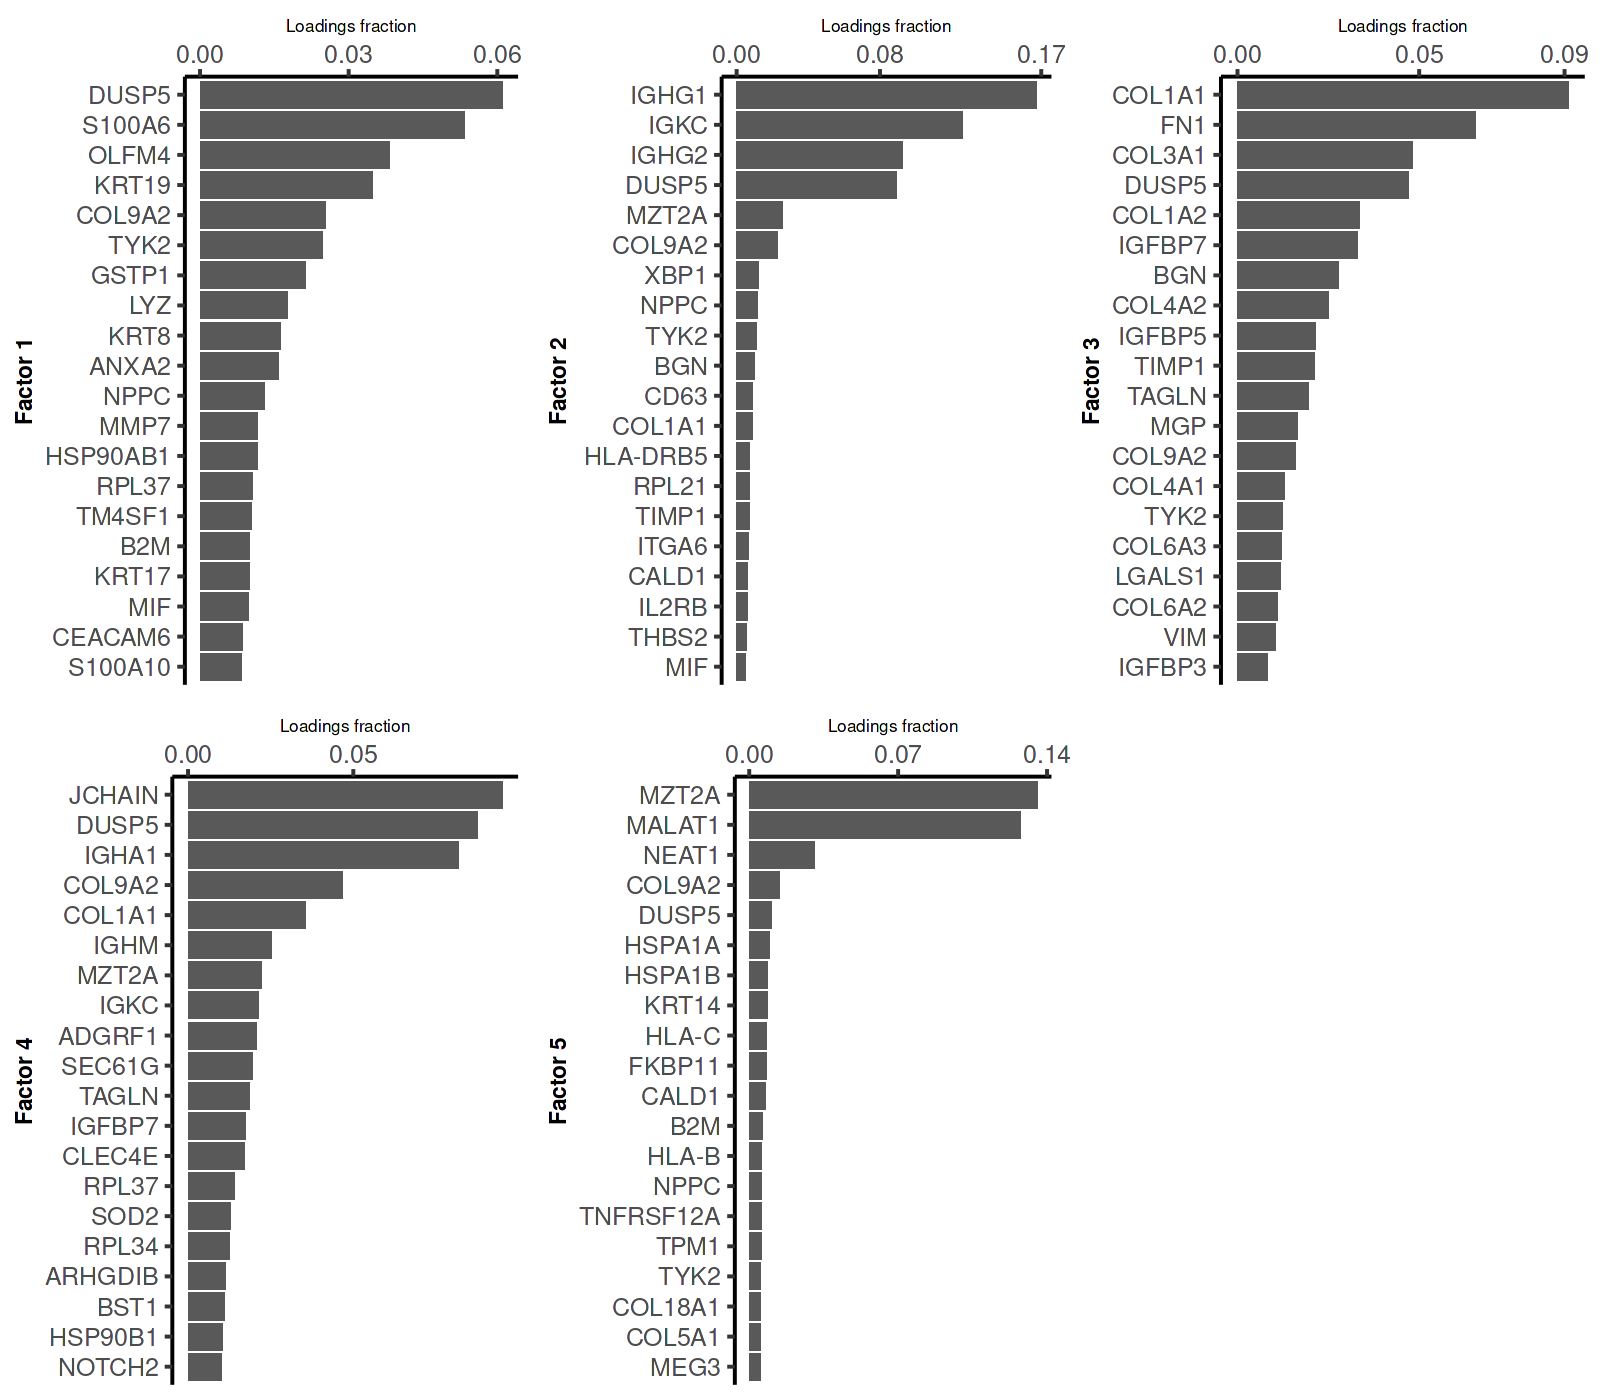

In [21]:
# Plot some loadings for the factors
options(repr.plot.width = 8, repr.plot.height = 7, repr.plot.res = 200)

my_plots <- lapply(
  c(1:k),
  function(i) {

    Hi = H %>% filter(factor == i)

    gene_order = Hi %>% arrange(-frac) %>% pull(gene) %>% head(20) %>% rev

    p_bar = Hi %>%
      filter(gene %in% gene_order) %>%
      mutate(gene = factor(gene, gene_order)) %>%
      ggplot(
        aes(x = frac, y = gene)
      ) +
      xlab('Loadings fraction') +
      ylab(paste0('Factor ',as.character(i))) +
      geom_col() +
      theme_classic(base_line_size = .5) +
      scale_x_continuous(breaks=round(seq(0, max(Hi$frac), max(Hi$frac)/2),digits = 2),position = "top") +
      theme(
        axis.title.x = element_text(size=6),
        axis.title.y = element_text(size=8,face="bold")
      )
      
    return(p_bar)
  }
) 

fig <- plot_grid(plotlist = my_plots,nrow=2,align = 'h')
fig

Here, factor 1 appears to represent admixture from malignant cells since several of the top loading genes are KRT19, KRT8, and KRT17, which are specific malignant markers. Note that the dataset downsampling step may cause these results to look slightly different from yours, so you will need to identify which factor corresponds to the malignant cell admixture and modify the following cell.

In [22]:
malignant_admix_factor <- 1

Next, we will run CRF to assign each molecule to one of these factors. Then, we can remove the molecules coming from contaminating cell types.

In [23]:
run_crf_ct <- function(df_ct,H) {
    #### running crf for all cells of the cell type
    crf_res = df_ct %>%
      split(.$cell, drop = T) %>%
      mclapply(
        function(df_c) {
          run_crf(df_c, H, k = k,h=5)
        },mc.preschedule=TRUE,mc.cores=5
      ) %>%
      bind_rows()

    rownames(df_ct) <- df_ct$mol_id
    crf_res <- cbind.data.frame(df_ct[crf_res$id,],crf_res)
    crf_res <- crf_res[,1:(ncol(crf_res)-1)]
    return(crf_res)
}

In [24]:
# run crf
df_fib_crf <- run_crf_ct(df,H)

# this appended a column 'factor' indicating which factor each molecule has been assigned to
head(df_fib_crf)


,fov,cell_ID,x,y,x_local_px,y_local_px,z,gene,CellComp,cell,celltype,mol_id,niche,id,factor
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
221062,1,1009,765.8845,28292.61,1066.025,1964.475,8.8,THBS1,Nuclear,c_1_1_1009,fibroblast,221062,tumor-stroma boundary,221062,3
221063,1,1009,767.7115,28289.52,1076.175,1947.325,8.8,FAS,Nuclear,c_1_1_1009,fibroblast,221063,tumor-stroma boundary,221063,3
221064,1,1009,768.6910,28293.16,1081.617,1967.533,2.4,HLA-A,Nuclear,c_1_1_1009,fibroblast,221064,tumor-stroma boundary,221064,5
221065,1,1009,766.9105,28291.75,1071.725,1959.700,2.4,NOTCH3,Nuclear,c_1_1_1009,fibroblast,221065,tumor-stroma boundary,221065,3
221066,1,1009,771.1882,28290.63,1095.490,1953.500,2.4,LYZ,Cytoplasm,c_1_1_1009,fibroblast,221066,tumor-stroma boundary,221066,1
221067,1,1009,771.1375,28289.93,1095.208,1949.617,2.4,HLA-DRB1,Cytoplasm,c_1_1_1009,fibroblast,221067,tumor-stroma boundary,221067,5


In [25]:
# now, remove the molecules assigned to the admixture factor
mol_id_keep <- rownames(df_fib_crf)[!(df_fib_crf$factor %in% malignant_admix_factor)]
df_fib_cln <- df_fib_crf[mol_id_keep,]

print(paste0('Number of molecules originally: ',nrow(df_fib_crf)))
print(paste0('Number of molecules after cleaning: ',nrow(df_fib_cln)))

[1] "Number of molecules originally: 3940608"
[1] "Number of molecules after cleaning: 3692508"


Next, we'll show that contamniating malignant marker gene expression is reduced in fibroblasts, while fibroblast markers remain unchanged post cleaning.

In [27]:
# compute a clean counts matrix from molecule level data
dat_cln <- df_fib_cln %>% count(gene, cell) %>%
      reshape2::dcast(cell ~ gene, value.var = 'n', fill = 0) %>%
      as.data.frame() %>%
      tibble::column_to_rownames('cell')
dat_cln <- t(dat_cln)

meta_cln <- unique(df_fib_cln[,c('cell','celltype','niche')])
colnames(meta_cln)[2] <- 'cell_type'
rownames(meta_cln) <- meta_cln$cell
meta_cln <- meta_cln[colnames(dat_cln),]

meta_cln$regions_compare <- sapply(meta_cln$niche,function(x) {
  if (x=='tumor interior') {
    return('tumor')
  } else if (x=='stroma') {
    return('stroma')
  } else {
    return(NA)
  }
})

rownames(meta_cln) <- meta_cln$cell

In [32]:
# reduce data to just the cells in the tested regions
cells_keep <- rownames(meta_cln)[!is.na(meta_cln$regions_compare)]
meta_cln <- meta_cln[cells_keep,]
dat_cln <- dat_cln[,cells_keep]

In [34]:
# normalize counts
dat_orig_norm <- sweep(dat_orig,2,colSums(dat_orig),'/')
dat_cln_norm <- sweep(dat_cln,2,colSums(dat_cln),'/')

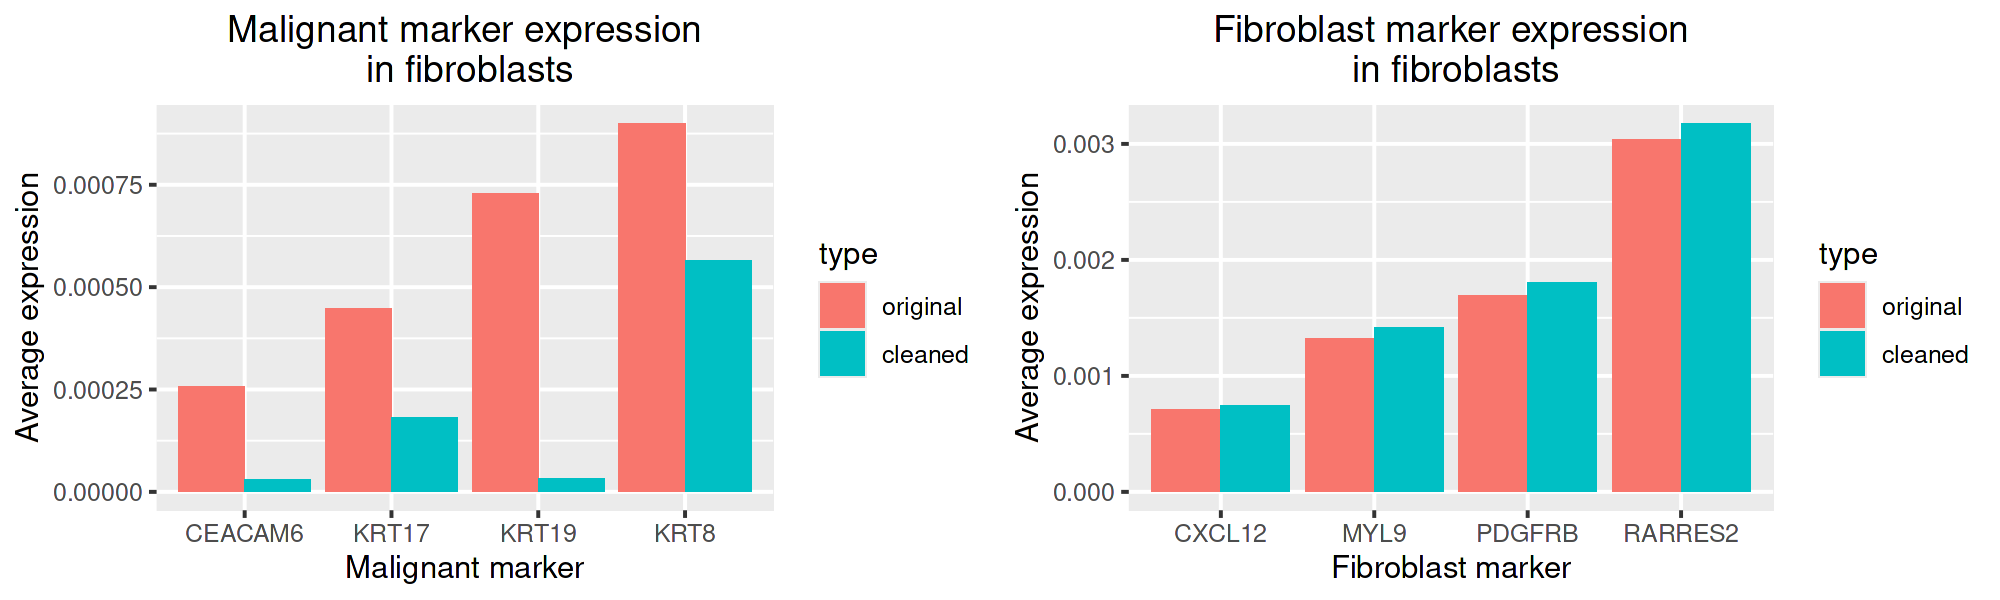

In [35]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)

malignant_marks <- c('KRT19','KRT8','KRT17','CEACAM6')
fibroblast_marks <- c('MYL9','CXCL12','PDGFRB','RARRES2')

mal_av_expr_before <- rowMeans(dat_orig_norm[malignant_marks,])
fib_av_expr_before <- rowMeans(dat_orig_norm[fibroblast_marks,])

mal_av_expr_after <- rowMeans(dat_cln_norm[malignant_marks,])
fib_av_expr_after <- rowMeans(dat_cln_norm[fibroblast_marks,])

tmp1a <- cbind.data.frame(malignant_marks,mal_av_expr_before,'original')
colnames(tmp1a) <- c('gene','av_expr','type')
tmp1b <- cbind.data.frame(malignant_marks,mal_av_expr_after,'cleaned')
colnames(tmp1b) <- c('gene','av_expr','type')
tmp1 <- rbind.data.frame(tmp1a,tmp1b)
tmp1$type <- factor(tmp1$type,levels=c('original','cleaned'))

p1 <- ggplot(tmp1,aes(x=gene,y=av_expr,fill=type)) +
    geom_bar(stat="identity", position=position_dodge()) +
    xlab('Malignant marker') +
    ylab('Average expression') +
    ggtitle('Malignant marker expression\n in fibroblasts') +
    theme(plot.title = element_text(hjust = 0.5))

tmp1a <- cbind.data.frame(fibroblast_marks,fib_av_expr_before,'original')
colnames(tmp1a) <- c('gene','av_expr','type')
tmp1b <- cbind.data.frame(fibroblast_marks,fib_av_expr_after,'cleaned')
colnames(tmp1b) <- c('gene','av_expr','type')
tmp1 <- rbind.data.frame(tmp1a,tmp1b)
tmp1$type <- factor(tmp1$type,levels=c('original','cleaned'))

p2 <- ggplot(tmp1,aes(x=gene,y=av_expr,fill=type)) +
    geom_bar(stat="identity", position=position_dodge()) +
    xlab('Fibroblast marker') +
    ylab('Average expression') +
    ggtitle('Fibroblast marker expression\n in fibroblasts') +
    theme(plot.title = element_text(hjust = 0.5))

cowplot::plot_grid(p1,p2,nrow=1)

Now, we show how this cleaning process mitigates the degree to which admixture dominates the DE results.

In [36]:
## run de for cleaned data
dat_pgda_cln <- basicP2proc(dat_cln, n.cores=1, min.cells.per.gene=0,
                        n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_cln$regions_compare
names(regions_compare) <- rownames(meta_cln)
de_out_cln <- dat_pgda_cln$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                        upregulated.only=FALSE,append.auc = TRUE)
de_out_cln <- de_out_cln[['tumor']]

# order genes the same in both de results matrixes
de_out_orig <- de_out_orig[rownames(de_out_cln),]

5819 cells, 980 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

26 overdispersed genes ... 26

persisting ... 

done.

running PCA using 980 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 1 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 976 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


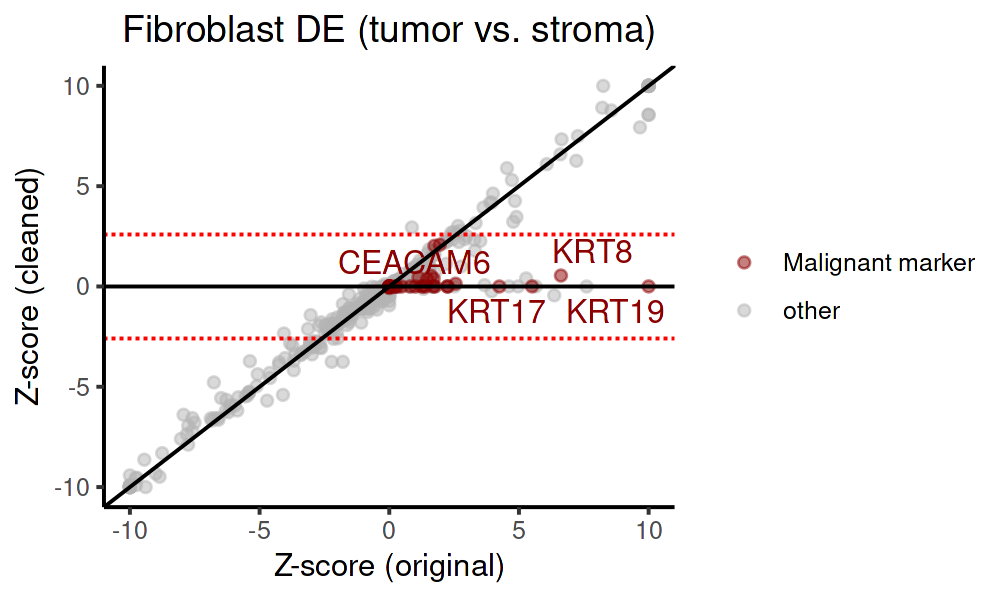

In [39]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)

#### plot DE comparison
z_thresh <- qnorm(.01/2,lower.tail = FALSE)
tmp <- cbind.data.frame(de_out_orig[,'Z'],de_out_cln[,'Z'])
colnames(tmp) <- c('orig','clean')
rownames(tmp) <- rownames(de_out_orig)

## trying to color points by tumor marker set belonging
tmp$markers <- sapply(rownames(tmp),function(x){
  if (x %in% tumor.marker.genes) {
    return('Malignant marker')
  } else {
    return('other')
  }
})
genes_to_label <- c('KRT19','KRT8','KRT17','CEACAM6')
ndx_lab <- match(genes_to_label,rownames(tmp))
genes_to_label <- genes_to_label[!is.na(ndx_lab)]
ndx_lab <- ndx_lab[!is.na(ndx_lab)]
tmp$glab <- NA
tmp[ndx_lab,'glab'] <- genes_to_label
z_upper_thresh <- 10
tmp[which(tmp$orig>z_upper_thresh),'orig'] <- z_upper_thresh
tmp[which(tmp$orig<(-z_upper_thresh)),'orig'] <- -z_upper_thresh
tmp[which(tmp$clean>z_upper_thresh),'clean'] <- z_upper_thresh
tmp[which(tmp$clean<(-z_upper_thresh)),'clean'] <- -z_upper_thresh
tmp$markers <- factor(tmp$markers,levels=c('other','Malignant marker'))
myColors <- c('red4','grey70')
p <- ggplot(tmp,aes(x=orig,y=clean,color=markers,label=glab)) +
  geom_point(data=tmp[tmp$markers=='other',],alpha=.5,size=1.5) +
  geom_point(data=tmp[tmp$markers=='Malignant marker',],alpha=.5,size=1.5) +
  geom_text_repel(size=4, show.legend = FALSE) +
  ggtitle('Fibroblast DE (tumor vs. stroma)') +
  xlab('Z-score (original)') +
  ylab('Z-score (cleaned)') +
  geom_hline(yintercept = z_thresh,color='red',linetype='dashed') +
  geom_hline(yintercept = -1*z_thresh,color='red',linetype='dashed') +
  geom_hline(yintercept = 0) +
  geom_abline(slope = 1,intercept=0) +
  scale_colour_manual(breaks = c('Malignant marker','other'), values = myColors) +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank())
p

We see that the fibroblast DE Z-scores for malignant cell markers are no longer significant after applying the cleaning procedure.